`cd project/seniorthesis/notebooks`

`mamba update cmip6_preprocessing -y`


In [2]:
import xarray as xr
from cmip6_preprocessing.preprocessing import combined_preprocessing
#import PyCO2SYS as pyco2 # i have to install this package through terminal for it to work
import intake
import matplotlib.pyplot as plt
import numpy as np
import warnings
import gsw
warnings.filterwarnings("ignore")
from cmip6_preprocessing.postprocessing import combine_datasets
from cartopy import crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import cmocean
import matplotlib.path as mpath

## @Abby you also need to plot at a few other depths (10m, 100m, 500m, etc) and plot `fgco2` (what is that?) and `pCO2` (probably depends on your pco2_calc code but that doesn't work yet so...)

In [3]:
col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")

In [6]:
cat_so_CESM = col.search(source_id = ['CESM2-FV2'], variable_id= 'so', experiment_id= 'historical', table_id = 'Omon', grid_label = 'gr')

dd_so_CESM = cat_so_CESM.to_dataset_dict(
    zarr_kwargs={'consolidated': True, 'use_cftime':True},
    storage_options={'token': 'anon'},
    preprocess=combined_preprocessing,
    aggregate=False)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


In [7]:
a = 'CMIP.NCAR.CESM2-FV2.historical.r1i1p1f1.Omon.so.gr.gs://cmip6/CMIP6/CMIP/NCAR/CESM2-FV2/historical/r1i1p1f1/Omon/so/gr/v20191120/.nan.20191120'
surf_so = dd_so_CESM[a]['so'].isel(lev = 0, time = 1)
surf_so

<xarray.DataArray 'so' (y: 180, x: 360)>
dask.array<getitem, shape=(180, 360), dtype=float32, chunksize=(180, 360), chunktype=numpy.ndarray>
Coordinates:
  * y        (y) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
    lev      float64 0.0
  * x        (x) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
    time     object 1850-02-14 00:00:00
    lon      (x, y) float64 0.5 0.5 0.5 0.5 0.5 ... 359.5 359.5 359.5 359.5
    lat      (x, y) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
Attributes:
    cell_measures:  area: areacello volume: volcello
    cell_methods:   area: mean where sea time: mean
    comment:        Model data on the 1x1 grid includes values in all cells f...
    description:    Sea water salinity is the salt content of sea water, ofte...
    frequency:      mon
    id:             so
    long_name:      Sea Water Salinity
    mipTable:       Omon
    out_name:       so
    prov:           Omon ((isd.003))
    realm:          ocean
    standard_name:  sea_water_salinity
    time:           time
    time_label:     time-mean
    time_title:     Temporal mean
    title:          Sea Water Salinity
    type:           real
    units:          0.001
    variable_id:    so

In [6]:
lat = dd_so_CESM[a].lat.transpose('y','x')
lon = dd_so_CESM[a].lon.transpose('y','x')
lon

<xarray.DataArray 'lon' (y: 180, x: 360)>
array([[  0.5,   1.5,   2.5, ..., 357.5, 358.5, 359.5],
       [  0.5,   1.5,   2.5, ..., 357.5, 358.5, 359.5],
       [  0.5,   1.5,   2.5, ..., 357.5, 358.5, 359.5],
       ...,
       [  0.5,   1.5,   2.5, ..., 357.5, 358.5, 359.5],
       [  0.5,   1.5,   2.5, ..., 357.5, 358.5, 359.5],
       [  0.5,   1.5,   2.5, ..., 357.5, 358.5, 359.5]])
Coordinates:
  * y        (y) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * x        (x) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
    lon      (y, x) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
    lat      (y, x) float64 -89.5 -89.5 -89.5 -89.5 ... 89.5 89.5 89.5 89.5

In [5]:
def draw_SOcustom(X,Y,Z,cmap,cbar_label,title,plot_type,**kwargs):
    
    crs_plot = ccrs.SouthPolarStereo()
    crs_source = ccrs.PlateCarree()
    
    fig,ax = plt.subplots(figsize=(10,10),subplot_kw={'projection':crs_plot})
    ax.add_feature(cfeature.LAND,zorder=10,facecolor='darkgray')
    ax.set_extent([-180, 180, -90, -30], crs_source)
    # Compute a circle in axes coordinates, which we can use as a boundary
    # for the map. We can pan/zoom as much as we like - the boundary will be
    # permanently circular.
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    
    ax.gridlines()
    ax.coastlines()
    
    ax.set_title(title,fontsize=14,pad = 20)
    
    if plot_type == 'contourf':
        im = ax.contourf(X,Y,Z,kwargs['clevs'],cmap=cmap,transform=crs_source)
    elif plot_type == 'pcolormesh':
        im = ax.pcolormesh(X,Y,Z,cmap=cmap,transform=crs_source,vmin=kwargs['clims'][0],vmax=kwargs['clims'][1])
    
    cbar = plt.colorbar(im,orientation='horizontal',fraction=0.025,pad=0.05)
    cbar.set_label(cbar_label,fontsize=12)
    
#     plt.show()
    
    return fig,ax

def pick_first_member(ds_list, **kwargs):
    return ds_list[0]


In [9]:
fig,ax = draw_SOcustom(lon.values,lat.values,surf_so,cmap='plasma',cbar_label='PSU',title='Surface Salinity',plot_type='contourf', clevs=np.arange(30,37,0.25))

In [25]:
dd_so_CESM[a].lat.values

array([[-89.5, -88.5, -87.5, ...,  87.5,  88.5,  89.5],
       [-89.5, -88.5, -87.5, ...,  87.5,  88.5,  89.5],
       [-89.5, -88.5, -87.5, ...,  87.5,  88.5,  89.5],
       ...,
       [-89.5, -88.5, -87.5, ...,  87.5,  88.5,  89.5],
       [-89.5, -88.5, -87.5, ...,  87.5,  88.5,  89.5],
       [-89.5, -88.5, -87.5, ...,  87.5,  88.5,  89.5]])

In [ ]:
a = 'CMIP.NCAR.CESM2-FV2.historical.r1i1p1f1.Omon.so.gr.gs://cmip6/CMIP6/CMIP/NCAR/CESM2-FV2/historical/r1i1p1f1/Omon/so/gr/v20191120/.nan.20191120'
surf_so = dd_so_CESM[a].so.isel(lev = 0, time = 1)
lat = dd_so_CESM[a].lat.transpose('y','x')
lon = dd_so_CESM[a].lon.transpose('y','x')
fig,ax = draw_SOcustom(lon.data,lat.values,surf_so,cmap='plasma',cbar_label='PSU',title='Surface Salinity',plot_type='contourf', clevs=np.arange(30,37,0.25))

## DIC

In [27]:
cat_DIC_all = col.search(source_id = ['E3SM-1-1','GFDL-ESM4','NorCPM1',
                                      'CESM2-FV2','CESM2','MRI-ESM2-0','CESM2-WACCM-FV2',
                                      'GFDL-CM4','CESM2-WACCM','E3SM-1-0','E3SM-1-1-ECA'], variable_id= 'dissic', experiment_id= 'historical', table_id = 'Omon', grid_label = 'gr')

dd_DIC_all_1 = cat_DIC_all.to_dataset_dict(
    zarr_kwargs={'consolidated': True, 'use_cftime':True},
    storage_options={'token': 'anon'},
    preprocess=combined_preprocessing,
    aggregate=False)

dd_DIC_all = combine_datasets(
    dd_DIC_all_1,
    pick_first_member,
    match_attrs=['source_id', 'grid_label', 'experiment_id', 'table_id'])

for name, ds in dd_DIC_all.items():
    print(ds.attrs['source_id']+' ' +ds.attrs['variant_label']+' ' +ds.attrs['table_id'])


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


CESM2 r6i1p1f1 Omon
CESM2-WACCM r1i1p1f1 Omon
CESM2-WACCM-FV2 r2i1p1f1 Omon
CESM2-FV2 r2i1p1f1 Omon
GFDL-ESM4 r1i1p1f1 Omon
MRI-ESM2-0 r1i2p1f1 Omon
GFDL-CM4 r1i1p1f1 Omon


In [28]:
dd_DIC_all

{'CESM2.gr.historical.Omon': <xarray.Dataset>
 Dimensions:        (bnds: 2, lev: 33, time: 1980, vertex: 4, x: 360, y: 180)
 Coordinates:
   * y              (y) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
     lat_bounds     (y, bnds, x) float64 dask.array<chunksize=(180, 2, 360), meta=np.ndarray>
   * lev            (lev) float64 0.0 10.0 20.0 30.0 ... 4.5e+03 5e+03 5.5e+03
     lev_bounds     (lev, bnds) float64 dask.array<chunksize=(33, 2), meta=np.ndarray>
   * x              (x) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
     lon_bounds     (x, bnds, y) float64 dask.array<chunksize=(360, 2, 180), meta=np.ndarray>
   * time           (time) object 1850-01-15 12:59:59.999997 ... 2014-12-15 12...
     time_bounds    (time, bnds) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
   * bnds           (bnds) int64 0 1
     lon            (x, y) float64 0.5 0.5 0.5 0.5 ... 359.5 359.5 359.5 359.5
     lat            (x, y) float64 -89.5 -88.5 -87.5 -86.5 ..

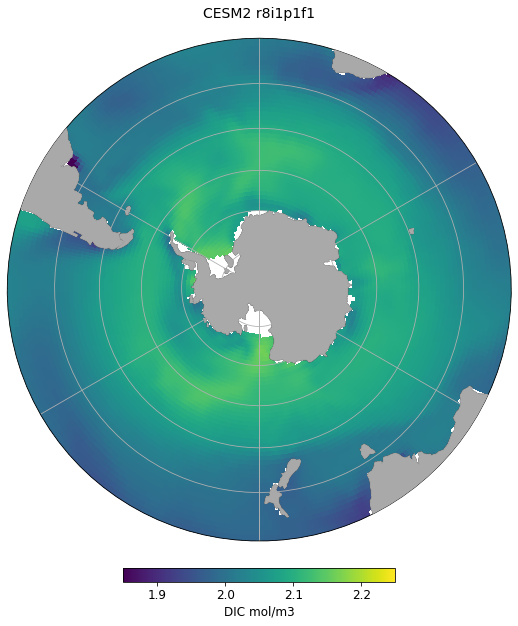

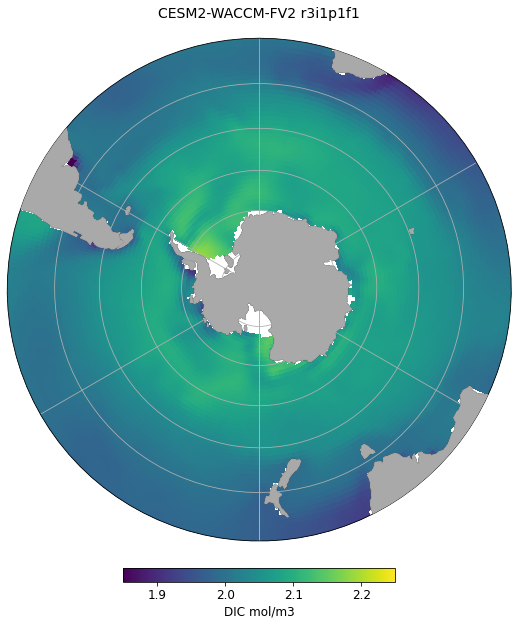

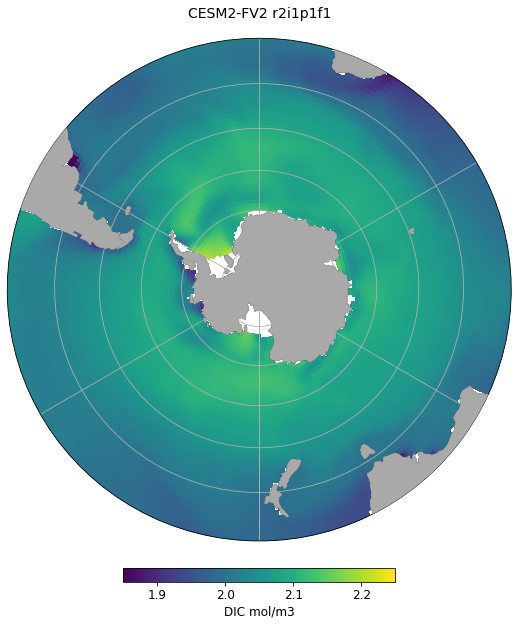

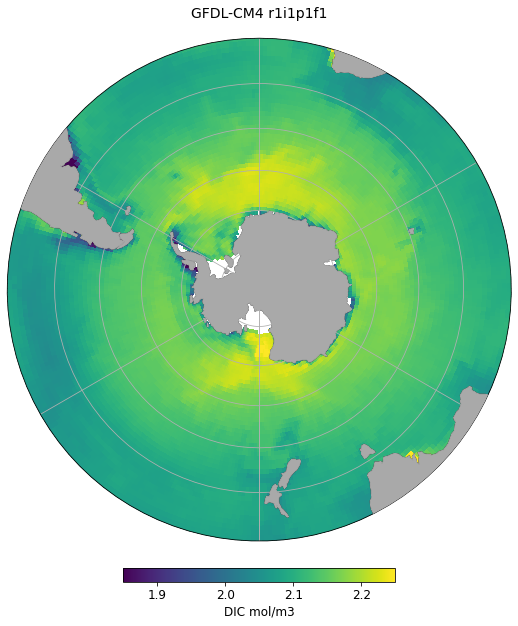

In [54]:
#You dont have to spell out all the axes, you can just keep them in an array
# fig_DIC, axarr_DIC = plt.subplots(nrows = 3, ncols = 3, figsize=[18,10])
# fig_DIC.tight_layout(pad = 3.5)
plt.rc('font', size = 12)
plt.rc('axes', titlesize= 10)    
plt.rc('axes', labelsize= 10)
plt.rc('figure', titlesize=14)

#loop over each key, value pair of the dictionary
ax_idx = 0 # index for your axes array
for name, ds_DIC in dd_DIC_all.items():
    #ax = axarr_DIC.flat[ax_idx]
    surf_dic = ds_DIC.dissic.isel(lev = 0, time = 1)
    lat = ds_DIC.lat.transpose('y','x')
    lon = ds_DIC.lon.transpose('y','x')
    draw_SOcustom(lon.data,lat.values,surf_dic,cmap='viridis',cbar_label='DIC mol/m3',title=ds_DIC.attrs['source_id']+ ' '+ds_DIC.attrs['variant_label'],plot_type='pcolormesh',clims=[1.85,2.25])
    #DIC_section = ds_DIC.dissic.where(np.logical_and(ds_DIC.lon<=200, ds_DIC.lon>=180), drop=True).isel(time = 0).mean('x', keep_attrs=True)
    #im = DIC_section.plot(x='y', y='lev', yincrease=False, ax = ax, cbar_kwargs={'label':'DIC mol/m3'})
#     ax.set_title(ds_DIC.attrs['source_id']+ ' '+ds_DIC.attrs['variant_label'])
#     ax.set_xlabel('Latitude')
#     ax.set_ylabel('Depth (m)')
#     ax.set_ylim([6000, 0])
    ax_idx += 1 # this is a nifty python trick to increment a variable by one


## Thetao

In [41]:
cat_thetao_all = col.search(source_id = ['E3SM-1-1','GFDL-ESM4','NorCPM1',
                                      'CESM2-FV2','CESM2','MRI-ESM2-0','CESM2-WACCM-FV2',
                                      'GFDL-CM4','CESM2-WACCM','E3SM-1-0','E3SM-1-1-ECA'], variable_id= 'thetao', experiment_id= 'historical', table_id = 'Omon', grid_label = 'gr')

dd_thetao_all_1 = cat_thetao_all.to_dataset_dict(
    zarr_kwargs={'consolidated': True, 'use_cftime':True},
    storage_options={'token': 'anon'},
    preprocess=combined_preprocessing,
    aggregate=False)

dd_thetao_all = combine_datasets(
    dd_thetao_all_1,
    pick_first_member,
    match_attrs=['source_id', 'grid_label', 'experiment_id', 'table_id'])

for name, ds in dd_thetao_all.items():
    print(ds.attrs['source_id']+' ' +ds.attrs['variant_label']+' ' +ds.attrs['table_id'])


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


CESM2 r7i1p1f1 Omon
NorCPM1 r4i1p1f1 Omon
CESM2-FV2 r2i1p1f1 Omon
GFDL-ESM4 r1i1p1f1 Omon
E3SM-1-1-ECA r1i1p1f1 Omon
E3SM-1-0 r2i1p1f1 Omon
CESM2-WACCM r2i1p1f1 Omon
MRI-ESM2-0 r1i2p1f1 Omon
GFDL-CM4 r1i1p1f1 Omon
CESM2-WACCM-FV2 r3i1p1f1 Omon
E3SM-1-1 r1i1p1f1 Omon


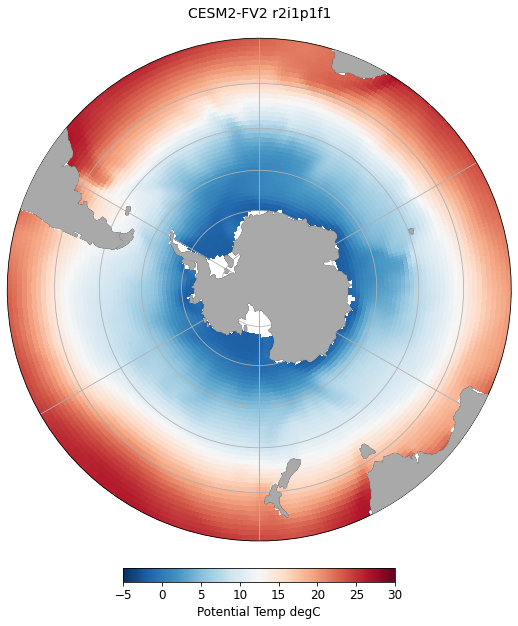

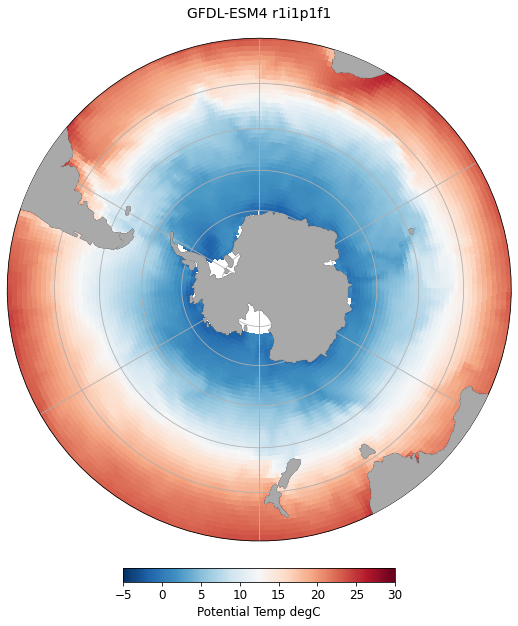

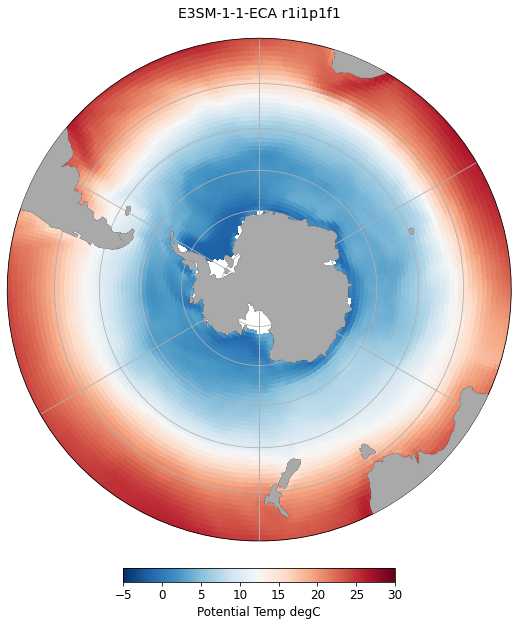

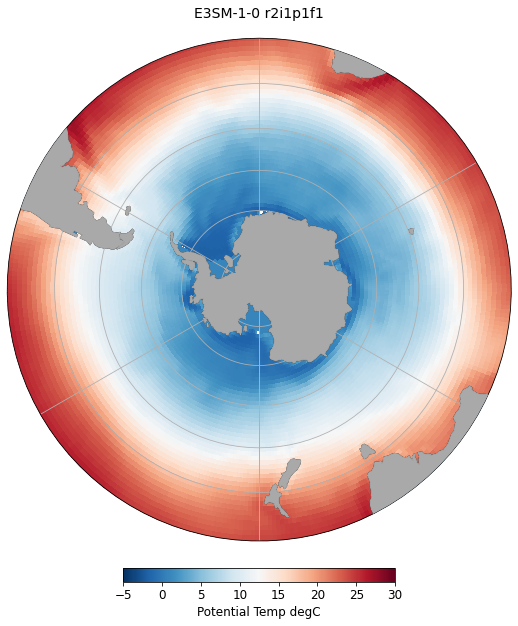

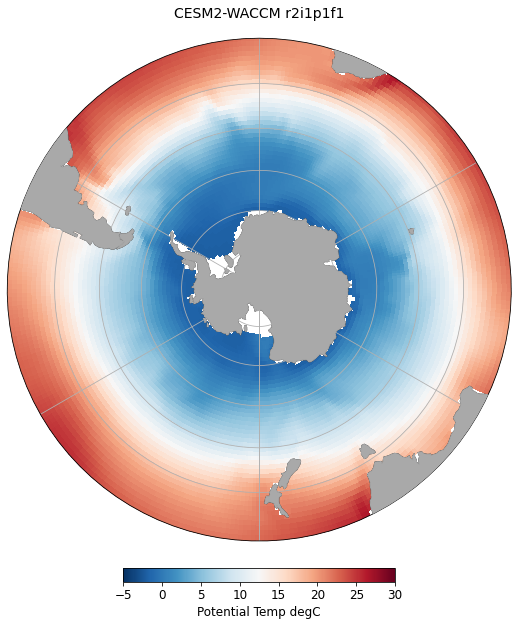

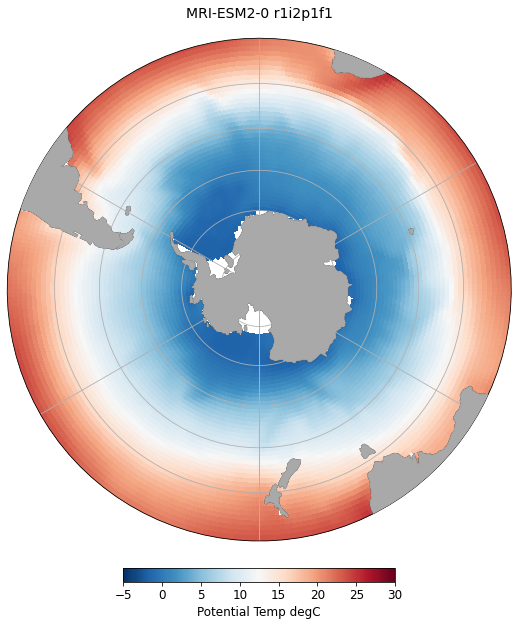

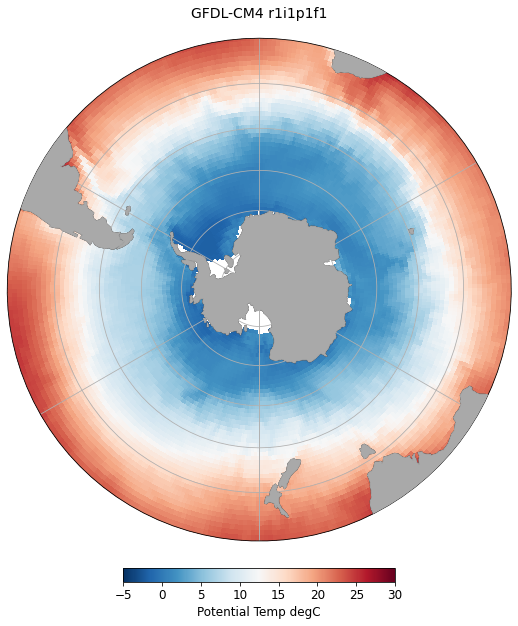

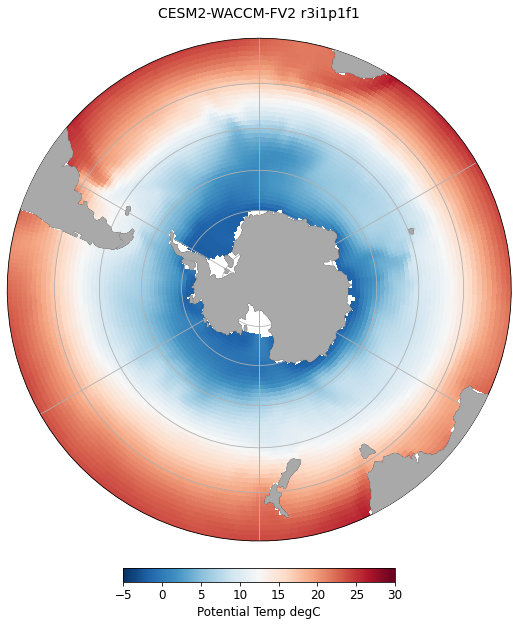

In [51]:
#loop over each key, value pair of the dictionary
ax_idx = 0 # index for your axes array
for name, ds_thetao in dd_thetao_all.items():
    #ax = axarr_DIC.flat[ax_idx]
    surf_thetao = ds_thetao.thetao.isel(lev = 0, time = 1)
    lat = ds_thetao.lat.transpose('y','x')
    lon = ds_thetao.lon.transpose('y','x')
    draw_SOcustom(lon.data,lat.values,surf_thetao,cmap='RdBu_r',cbar_label='Potential Temp degC',title=ds_thetao.attrs['source_id']+ ' '+ds_thetao.attrs['variant_label'],plot_type='pcolormesh',clims=[-5,30])
    ax_idx += 1 # this is a nifty python trick to increment a variable by one

## Talk

In [42]:
cat_talk_all = col.search(source_id = ['E3SM-1-1','GFDL-ESM4','NorCPM1',
                                      'CESM2-FV2','CESM2','MRI-ESM2-0','CESM2-WACCM-FV2',
                                      'GFDL-CM4','CESM2-WACCM','E3SM-1-0','E3SM-1-1-ECA'], variable_id= 'talk', experiment_id= 'historical', table_id = 'Omon', grid_label = 'gr')

dd_talk_all_1 = cat_talk_all.to_dataset_dict(
    zarr_kwargs={'consolidated': True, 'use_cftime':True},
    storage_options={'token': 'anon'},
    preprocess=combined_preprocessing,
    aggregate=False)

dd_talk_all = combine_datasets(
    dd_talk_all_1,
    pick_first_member,
    match_attrs=['source_id', 'grid_label', 'experiment_id', 'table_id'])

for name, ds in dd_talk_all.items():
    print(ds.attrs['source_id']+' ' +ds.attrs['variant_label']+' ' +ds.attrs['table_id'])


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


CESM2 r1i1p1f1 Omon
NorCPM1 r20i1p1f1 Omon
CESM2-FV2 r1i1p1f1 Omon
CESM2-WACCM-FV2 r3i1p1f1 Omon
CESM2-WACCM r2i1p1f1 Omon
GFDL-CM4 r1i1p1f1 Omon
GFDL-ESM4 r1i1p1f1 Omon
MRI-ESM2-0 r1i2p1f1 Omon


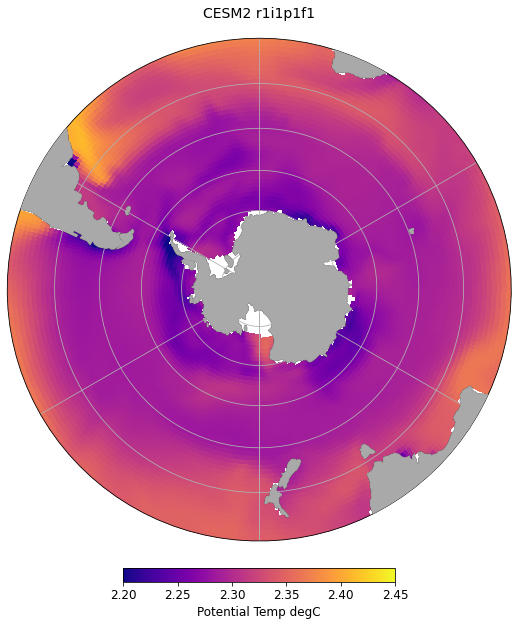

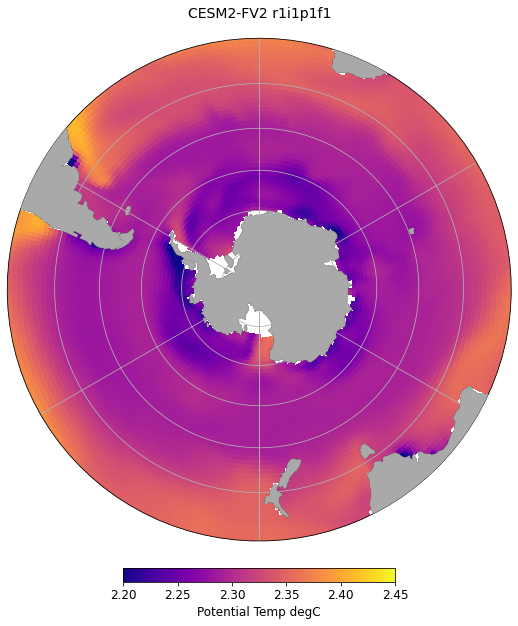

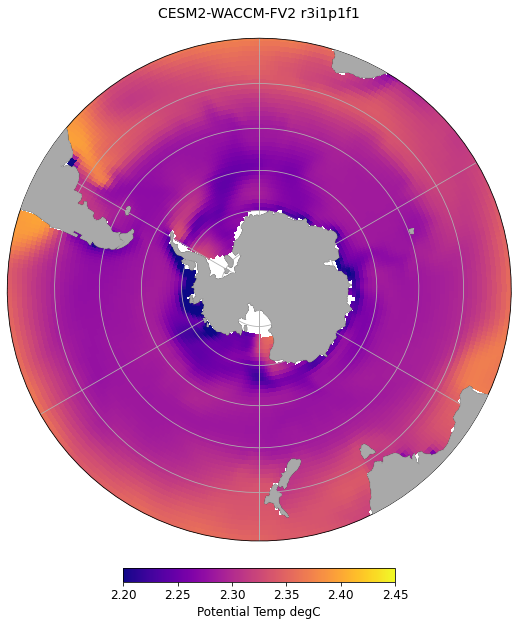

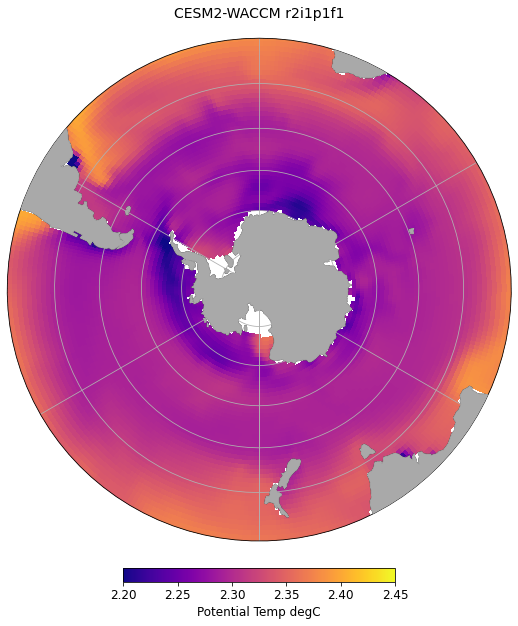

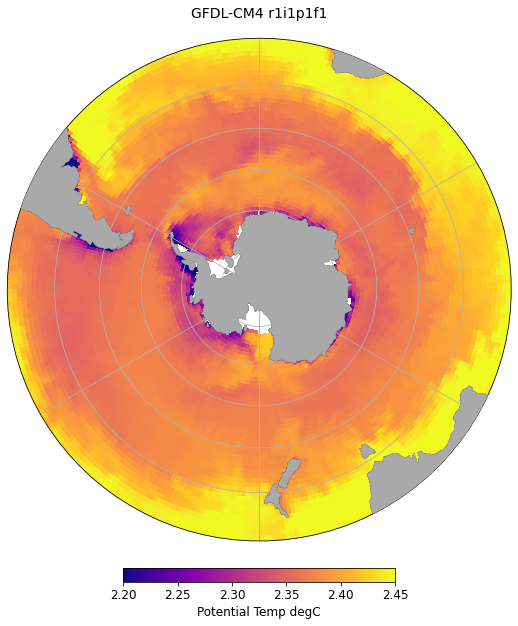

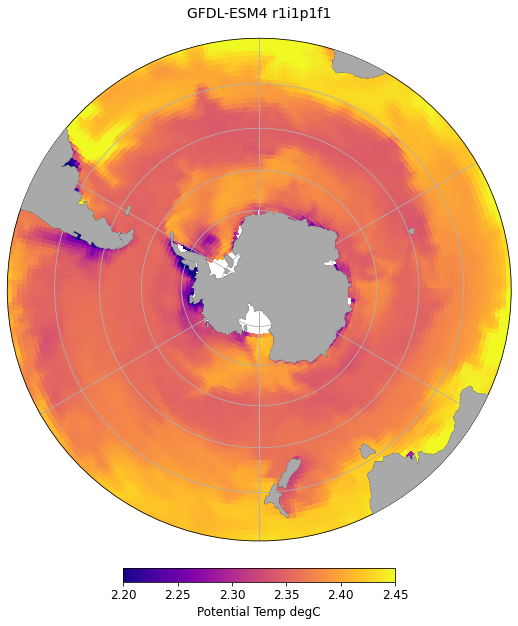

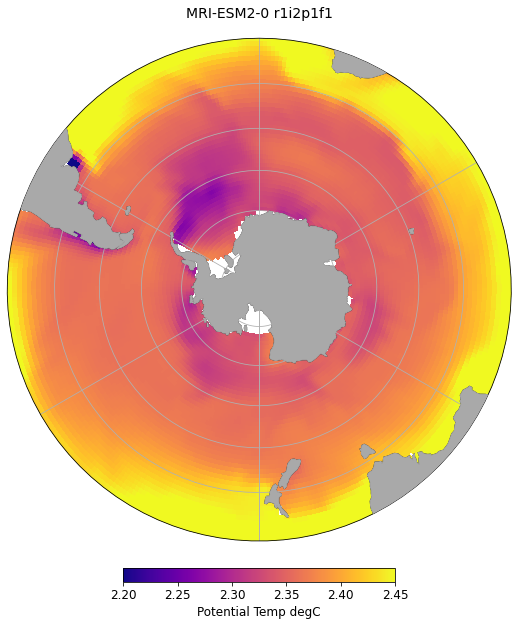

In [59]:
#loop over each key, value pair of the dictionary
ax_idx = 0 # index for your axes array
for name, ds_talk in dd_talk_all.items():
    #ax = axarr_DIC.flat[ax_idx]
    surf_talk = ds_talk.talk.isel(lev = 0, time = 1)
    lat = ds_talk.lat.transpose('y','x')
    lon = ds_talk.lon.transpose('y','x')
    draw_SOcustom(lon.data,lat.values,surf_talk,cmap='plasma',cbar_label='Potential Temp degC',title=ds_talk.attrs['source_id']+ ' '+ds_talk.attrs['variant_label'],plot_type='pcolormesh',clims=[2.2,2.45])
    ax_idx += 1 # this is a nifty python trick to increment a variable by one

## Salinity

In [7]:
cat_so_all = col.search(source_id = ['E3SM-1-1','GFDL-ESM4','NorCPM1',
                                      'CESM2-FV2','CESM2','MRI-ESM2-0','CESM2-WACCM-FV2',
                                      'GFDL-CM4','CESM2-WACCM','E3SM-1-0','E3SM-1-1-ECA'], variable_id= 'so', experiment_id= 'historical', table_id = 'Omon', grid_label = 'gr')

dd_so_all_1 = cat_so_all.to_dataset_dict(
    zarr_kwargs={'consolidated': True, 'use_cftime':True},
    storage_options={'token': 'anon'},
    preprocess=combined_preprocessing,
    aggregate=False)

dd_so_all = combine_datasets(
    dd_so_all_1,
    pick_first_member,
    match_attrs=['source_id', 'grid_label', 'experiment_id', 'table_id'])

for name, ds in dd_so_all.items():
    print(ds.attrs['source_id']+' ' +ds.attrs['variant_label']+' ' +ds.attrs['table_id'])


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


NorCPM1 r28i1p1f1 Omon
MRI-ESM2-0 r1i1p1f1 Omon
CESM2-WACCM r1i1p1f1 Omon
CESM2 r3i1p1f1 Omon
E3SM-1-1 r1i1p1f1 Omon
E3SM-1-1-ECA r1i1p1f1 Omon
GFDL-ESM4 r1i1p1f1 Omon
E3SM-1-0 r1i1p1f1 Omon
CESM2-FV2 r1i1p1f1 Omon
CESM2-WACCM-FV2 r1i1p1f1 Omon
GFDL-CM4 r1i1p1f1 Omon


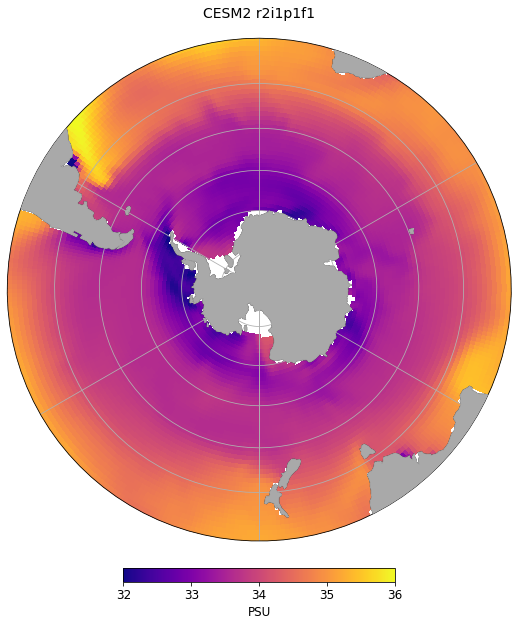

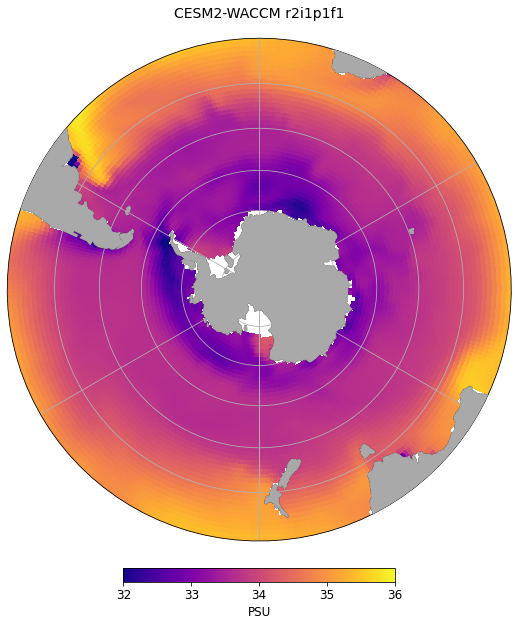

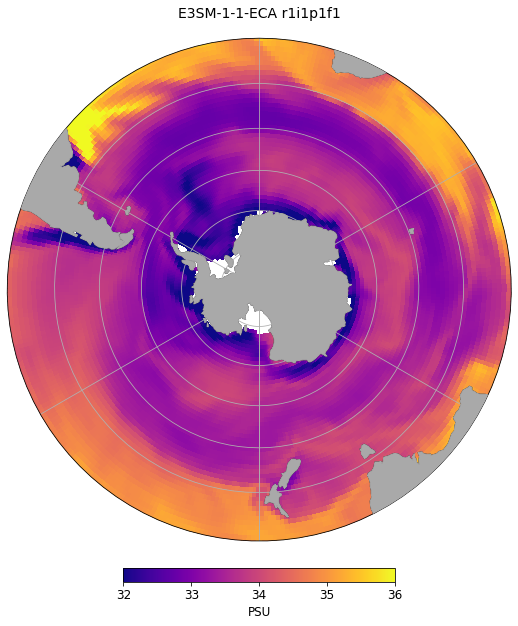

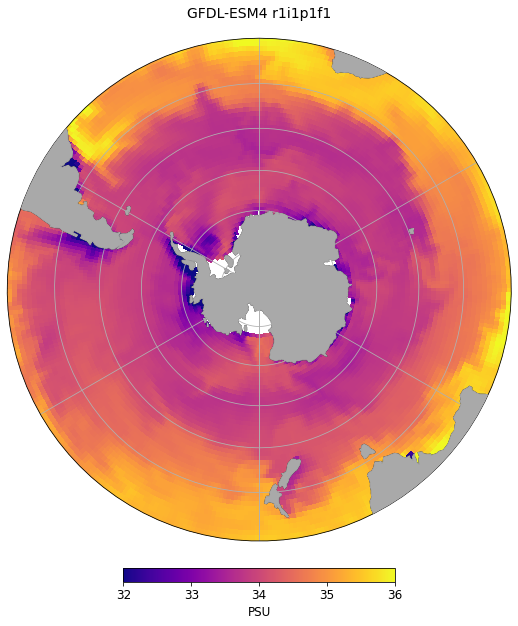

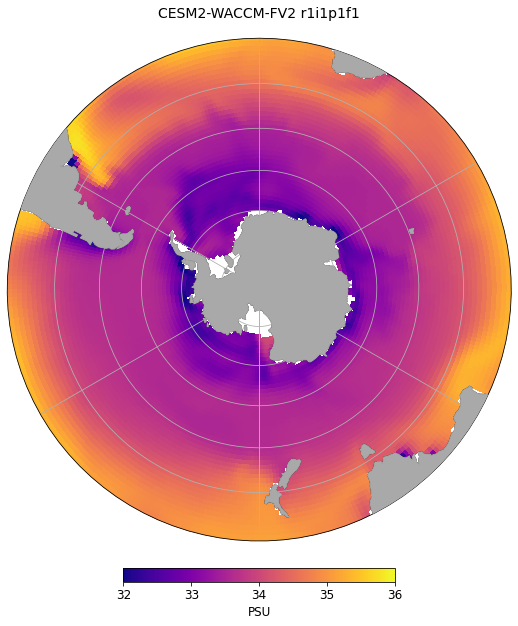

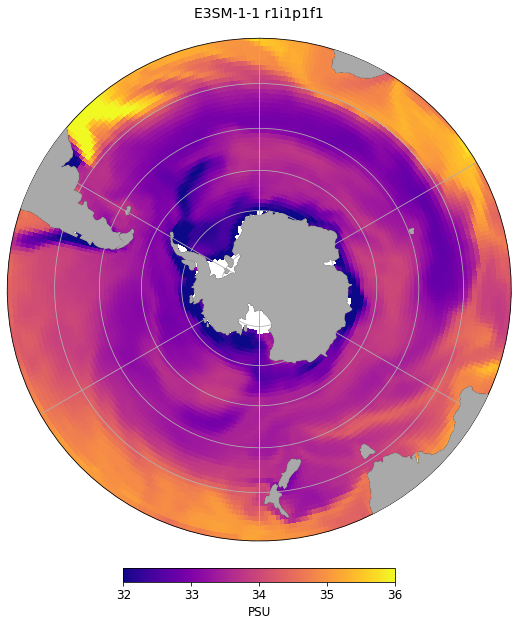

In [55]:
#loop over each key, value pair of the dictionary
ax_idx = 0 # index for your axes array
for name, ds_so in dd_so_all.items():
    #ax = axarr_DIC.flat[ax_idx]
    surf_so = ds_so.so.isel(lev = 0, time = 1)
    lat = ds_so.lat.transpose('y','x')
    lon = ds_so.lon.transpose('y','x')
    draw_SOcustom(lon.data,lat.values,surf_so,cmap='plasma',cbar_label='PSU',title=ds_so.attrs['source_id']+ ' '+ds_so.attrs['variant_label'],plot_type='pcolormesh',clims=[32,36])
    ax_idx += 1 # this is a nifty python trick to increment a variable by one

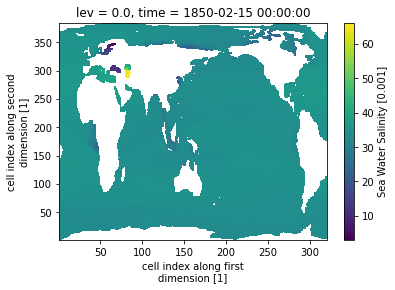

In [8]:
# dd_so_all['NorCPM1.gr.historical.Omon'].so.plot()
dd_so_all['NorCPM1.gr.historical.Omon'].so.isel(lev = 0, time = 1).plot()

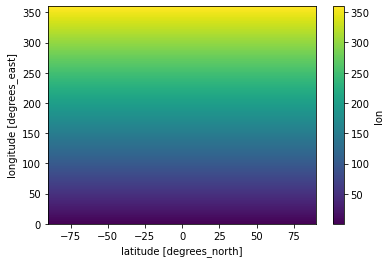

In [14]:
dd_so_all['CESM2-WACCM.gr.historical.Omon'].lon.plot()

In [63]:
dd_thetao_all['NorCPM1.gr.historical.Omon']

<xarray.Dataset>
Dimensions:        (bnds: 2, lev: 35, time: 2160, vertex: 4, x: 320, y: 384)
Coordinates:
  * x              (x) int32 1 2 3 4 5 6 7 8 ... 313 314 315 316 317 318 319 320
  * y              (y) int32 1 2 3 4 5 6 7 8 ... 377 378 379 380 381 382 383 384
    lat            (y, x) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * lev            (lev) float64 0.0 10.0 20.0 30.0 ... 5.5e+03 6e+03 6.5e+03
    lev_bounds     (lev, bnds) float64 dask.array<chunksize=(35, 2), meta=np.ndarray>
    lon            (y, x) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * time           (time) object 1850-01-16 12:00:00 ... 2029-12-16 12:00:00
    time_bounds    (time, bnds) object dask.array<chunksize=(2160, 2), meta=np.ndarray>
    lat_verticies  (y, x, vertex) float64 dask.array<chunksize=(384, 320, 4), meta=np.ndarray>
    lon_verticies  (y, x, vertex) float64 dask.array<chunksize=(384, 320, 4), meta=np.ndarray>
  * bnds           (bnds) int64 0 1
  * vertex         (vertex) int64 0 1 2 3
    lon_bounds     (bnds, y, x) float64 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    lat_bounds     (bnds, y, x) float64 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
Data variables:
    thetao         (time, lev, y, x) float32 dask.array<chunksize=(7, 35, 384, 320), meta=np.ndarray>
Attributes:
    Conventions:               CF-1.7 CMIP-6.2
    activity_id:               CMIP
    branch_method:             perturbations to atmospheric fields were appli...
    branch_time:               674885.0
    branch_time_in_child:      674885.0
    branch_time_in_parent:     674885.0
    cmor_version:              3.5.0
    contact:                   Please send any requests or bug reports to nor...
    creation_date:             2019-09-16T04:04:55Z
    data_specs_version:        01.00.31
    experiment:                all-forcing simulation of the recent past
    experiment_id:             historical
    external_variables:        areacello volcello
    forcing_index:             1
    frequency:                 mon
    further_info_url:          https://furtherinfo.es-doc.org/CMIP6.NCC.NorCP...
    grid:                      displaced-pole grid, centered at Greenland, wi...
    grid_label:                gr
    history:                   2019-09-16T04:04:55Z ; CMOR rewrote data to be...
    initialization_index:      1
    institution:               NorESM Climate modeling Consortium consisting ...
    institution_id:            NCC
    license:                   CMIP6 model data produced by NCC is licensed u...
    mip_era:                   CMIP6
    model_id:                  NorCPM1
    nominal_resolution:        100 km
    parent_activity_id:        CMIP
    parent_experiment_id:      piControl
    parent_mip_era:            CMIP6
    parent_source_id:          NorCPM1
    parent_sub_experiment_id:  none
    parent_time_units:         days since 0001-01-01
    parent_variant_label:      r1i1p1f1
    physics_index:             1
    product:                   model-output
    realization_index:         4
    realm:                     ocean
    references:                Bethke et al. (in prep), NorCPM1 and its contr...
    run_variant:               N/A
    source:                    NorCPM1 (2019): \naerosol: OsloAero4.1 (same g...
    source_id:                 NorCPM1
    source_type:               AOGCM
    status:                    2020-07-14;created; by gcs.cmip6.ldeo@gmail.com
    sub_experiment:            none
    sub_experiment_id:         none
    table_id:                  Omon
    table_info:                Creation Date:(24 July 2019) MD5:f0588f7f55b57...
    title:                     NorCPM1 output prepared for CMIP6
    tracking_id:               hdl:21.14100/bcf9c493-0e04-4b6e-9099-fb19ffe5a...
    variable_id:               thetao
    variant_label:             r4i1p1f1
    netcdf_tracking_ids:       hdl:21.14100/bcf9c493-0e04-4b6e-9099-fb19ffe5a...
    version_id:            

In [15]:
cat_fgco2_all = col.search(source_id = ['E3SM-1-1','GFDL-ESM4','NorCPM1',
                                      'CESM2-FV2','CESM2','MRI-ESM2-0','CESM2-WACCM-FV2',
                                      'GFDL-CM4','CESM2-WACCM','E3SM-1-0','E3SM-1-1-ECA'], variable_id= 'fgco2', experiment_id= 'historical', table_id = 'Omon', grid_label = 'gr')

dd_fgco2_all_1 = cat_fgco2_all.to_dataset_dict(
    zarr_kwargs={'consolidated': True, 'use_cftime':True},
    storage_options={'token': 'anon'},
    preprocess=combined_preprocessing,
    aggregate=False)

dd_fgco2_all = combine_datasets(
    dd_fgco2_all_1,
    pick_first_member,
    match_attrs=['source_id', 'grid_label', 'experiment_id', 'table_id'])

for name, ds in dd_fgco2_all.items():
    print(ds.attrs['source_id']+' ' +ds.attrs['variant_label']+' ' +ds.attrs['table_id'])


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


CESM2-WACCM r2i1p1f1 Omon
CESM2-WACCM-FV2 r3i1p1f1 Omon
GFDL-ESM4 r1i1p1f1 Omon
GFDL-CM4 r1i1p1f1 Omon
CESM2 r8i1p1f1 Omon
MRI-ESM2-0 r1i2p1f1 Omon
CESM2-FV2 r3i1p1f1 Omon


In [17]:
def stereo_proj_fgco2(z, t, cols, lbl, low, high):
    
    cat = cols.search(source_id = ['E3SM-1-1','GFDL-ESM4','NorCPM1',
                                      'CESM2-FV2','CESM2','MRI-ESM2-0','CESM2-WACCM-FV2',
                                      'GFDL-CM4','CESM2-WACCM','E3SM-1-0','E3SM-1-1-ECA'], variable_id= 'fgco2', experiment_id= 'historical', table_id = 'Omon', grid_label = 'gr')

    dd_all = cat.to_dataset_dict(
        zarr_kwargs={'consolidated': True, 'use_cftime':True},
        storage_options={'token': 'anon'},
        preprocess=combined_preprocessing,
        aggregate=False)

    dd = combine_datasets(
        dd_all,
        pick_first_member,
        match_attrs=['source_id', 'grid_label', 'experiment_id', 'table_id'])

    #loop over each key, value pair of the dictionary
    ax_idx = 0 # index for your axes array
    for name, ds in dd.items():
        #ax = axarr_DIC.flat[ax_idx]
        surf = ds.fgco2.isel(lev = z, time = t)
        lat = ds.lat.transpose('y','x')
        lon = ds.lon.transpose('y','x')
        draw_SOcustom(lon.data,lat.values,surf,cmap='plasma',cbar_label= lbl,title=ds.attrs['source_id']+ ' '+ds.attrs['variant_label'],plot_type='pcolormesh',clims=[low,high])
        ax_idx += 1 # this is a nifty python trick to increment a variable by one


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


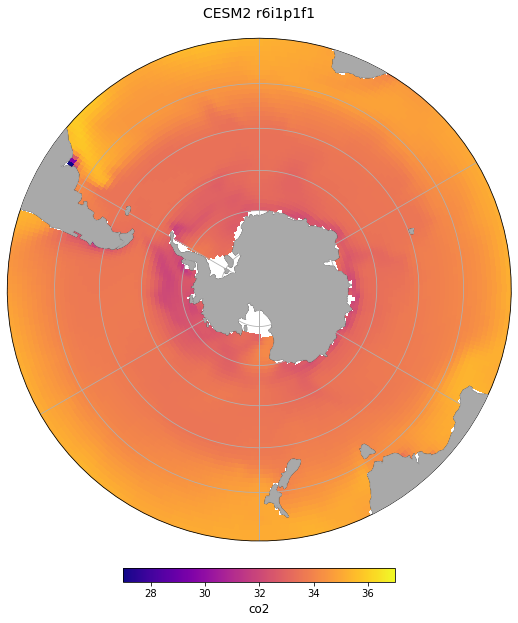

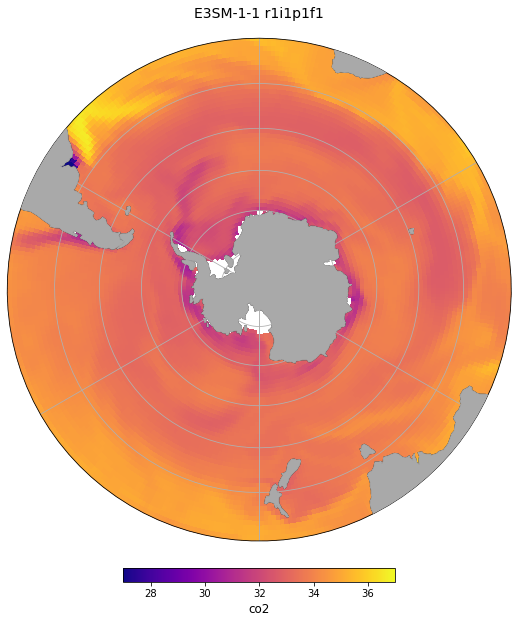

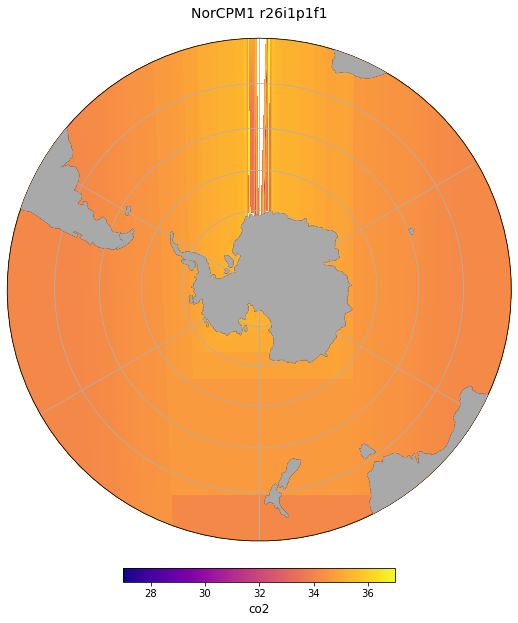

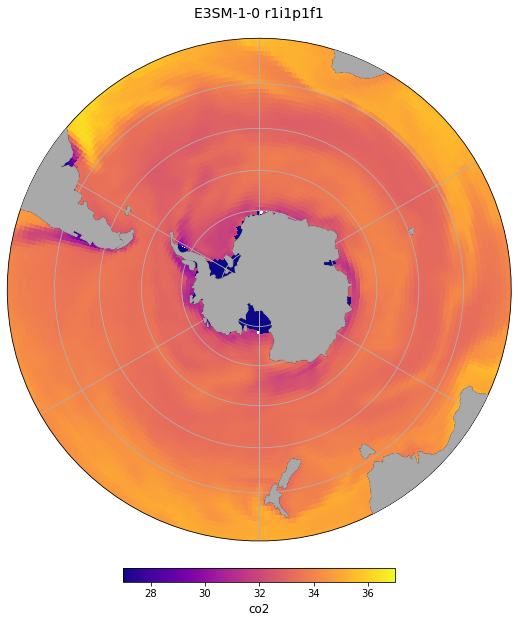

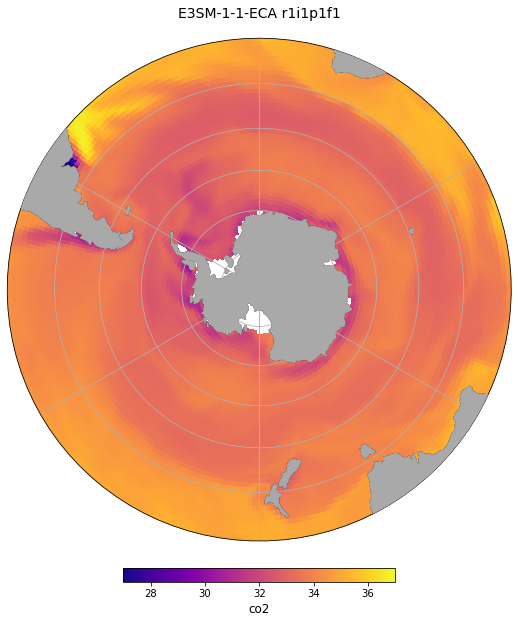

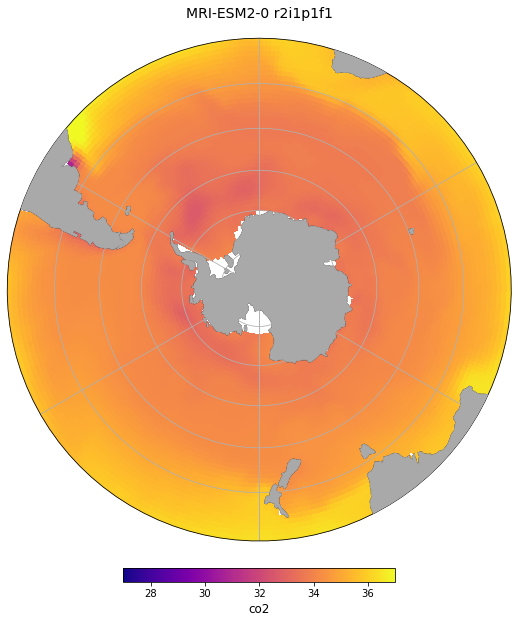

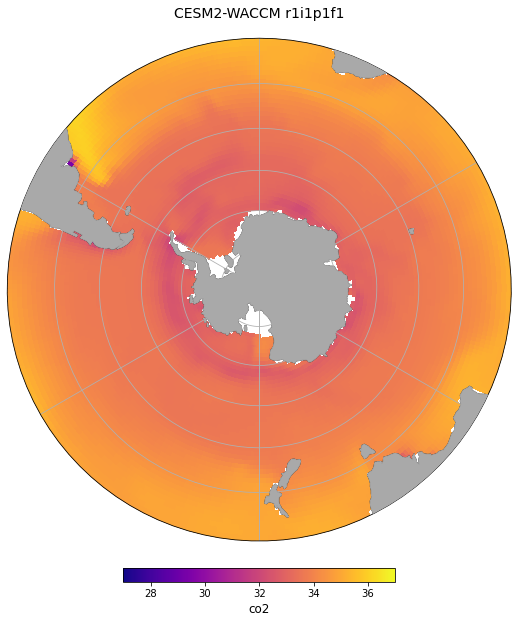

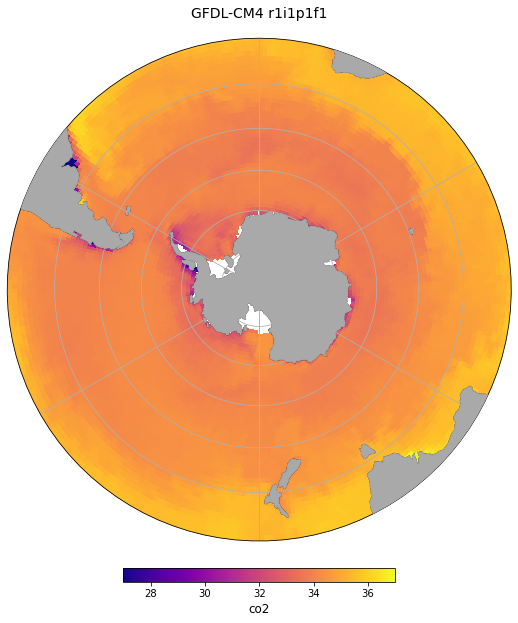

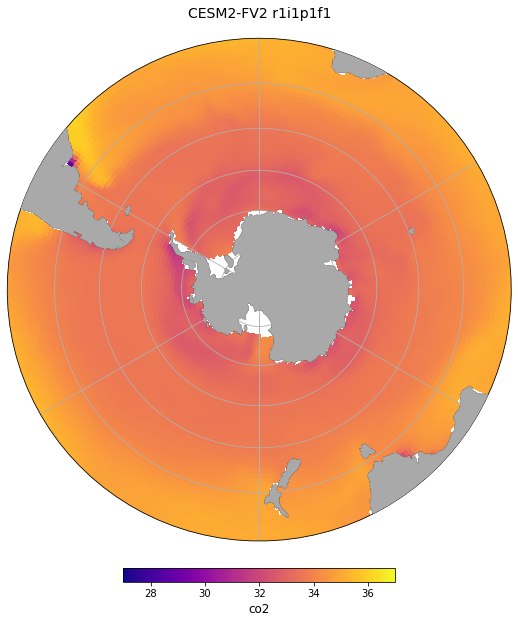

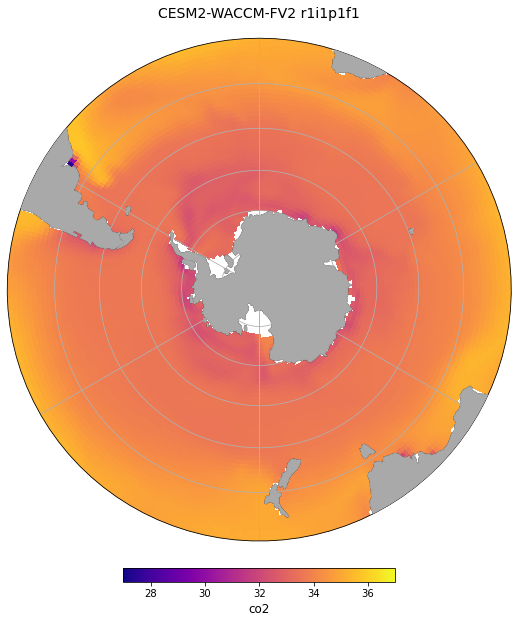

In [23]:
multiple_stereo_proj(0, 1, col, 'co2', 27, 37)